In [1]:
from datetime import datetime
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from vnstock3 import Vnstock
import pandas_ta as ta
import numpy as np
import F 

In [2]:
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2023-01-01', end = current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2023-01-01', end = current_date, to_df=True)

2024-06-29 14:37:08,079 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-06-29 14:37:08,173 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [3]:
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index()
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)

    # Thêm chỉ báo EMA
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)

    # Thêm chỉ báo RSI
    data['rsi'] = ta.rsi(data['close'], length=14)

    # Thêm chỉ báo MACD
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index()
    return data

In [4]:
data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

In [5]:
def model_ARIMA(data):
    data = data[['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
    stepwise_model = auto_arima(data['close'], trace=True, suppress_warnings=True, stepwise=True)
    model = ARIMA(data['close'], order=stepwise_model.order)
    model_fit = model.fit()
    return model_fit

def output_ARIMA(data, trend):
    data_features = data[['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
    if data_features.isnull().values.any():
        raise ValueError("Train data contains NaN values.")
    
    model = model_ARIMA(data_features)
    next_day_forecast = model.forecast(steps=10)
    
    return np.mean(next_day_forecast)

In [6]:
def test(data, k):
    # Ensure the 'Price' column is properly referenced
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Calculate predicted price for each row starting from index k
    for i in range(k, len(data)):
        # Get data for the previous k days to predict the price for the current day
        historical_data = data.iloc[i-k:i][['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
        
        # Assuming output_ARIMA returns the predicted price based on previous data
        predicted_price = output_ARIMA(historical_data, k)
        
        # Calculate the price difference between the last day in the prediction data and the predicted price
        price_difference = predicted_price - data.iloc[i-1]['close']  # Make sure 'price' is correctly referenced

        # Update position based on calculated price difference
        if price_difference > 2:
            data_output.loc[i, 'position'] = 1
        elif price_difference < -2:
            data_output.loc[i, 'position'] = -1
    data_output.dropna(inplace = True)
    return data_output

In [7]:
%%capture
data_VNI_position = test(data_VNI, 30)
data_VN30_position = test(data_VN30, 30)

Margin: 12.478003122832169
MDD: (129.87333333333336, 0.10166448788099397)

   Total trading quantity: 28
         Profit per trade: 2.8760714285714277
             Total Profit: 80.5
         Profit after fee: 68.8
 Trading quantity per day: 0.08333333333333333
 Profit per day after fee: 0.20476190476190476
                   Return: 0.040035854345952415
          Profit per year: 51.14460285132383
                  HitRate: 0.6071428571428571
          HitRate per day: 0.14328358208955225


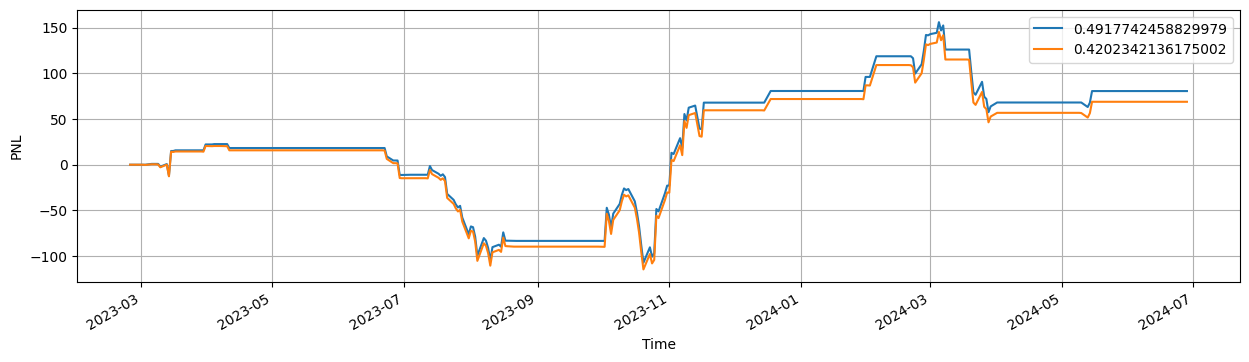

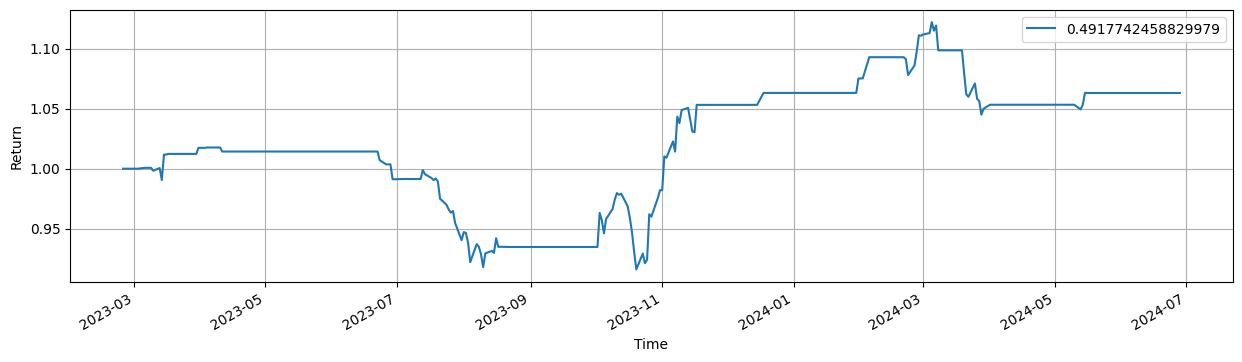

In [8]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 32.4715502753372
MDD: (68.41678571428581, 0.05332189146068149)

   Total trading quantity: 34
         Profit per trade: 7.49382352941177
             Total Profit: 254.8
         Profit after fee: 240.4
 Trading quantity per day: 0.10119047619047619
 Profit per day after fee: 0.7154761904761905
                   Return: 0.13927998631231991
          Profit per year: 178.70875763747455
                  HitRate: 0.5882352941176471
          HitRate per day: 0.1582089552238806


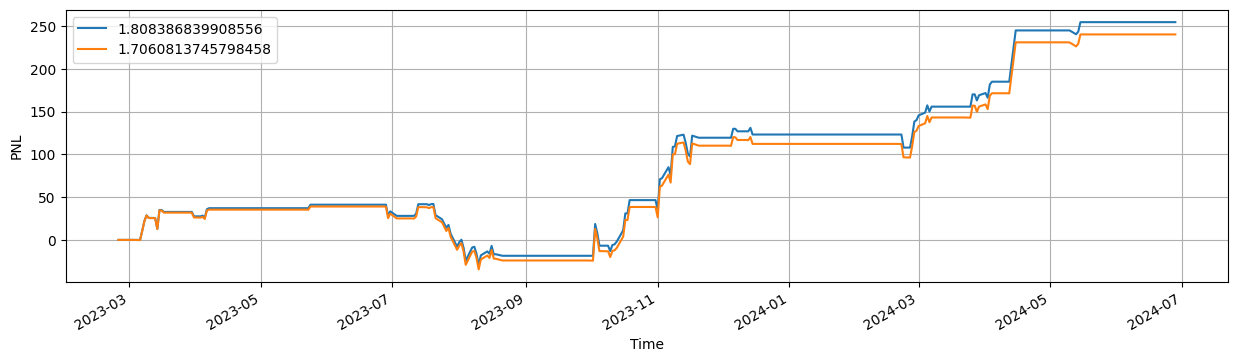

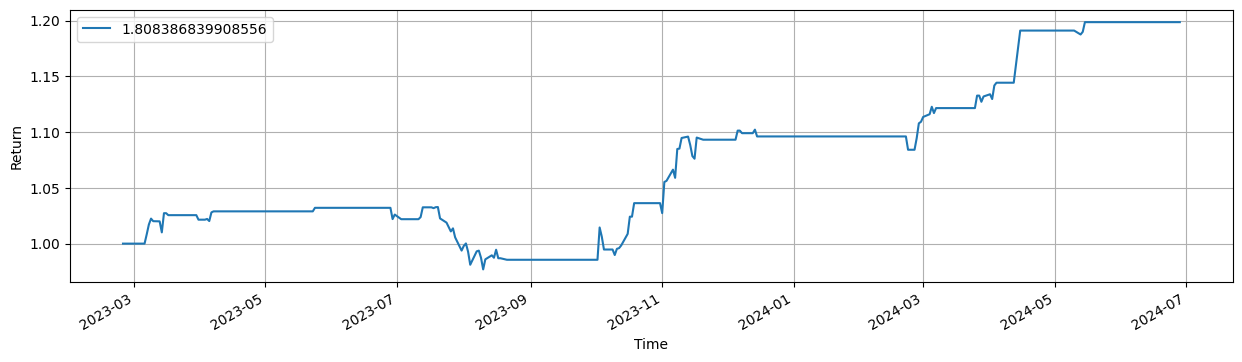

In [9]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [10]:
%%capture
data_VNI_position = test(data_VNI, 15)
data_VN30_position = test(data_VN30, 15)

Margin: 7.23764719704895
MDD: (82.73964285714291, 0.06348959703586779)

   Total trading quantity: 54
         Profit per trade: 1.6883333333333095
             Total Profit: 91.2
         Profit after fee: 67.7
 Trading quantity per day: 0.16071428571428573
 Profit per day after fee: 0.20148809523809524
                   Return: 0.03861792810803174
          Profit per year: 50.32688391038697
                  HitRate: 0.5
          HitRate per day: 0.21791044776119403


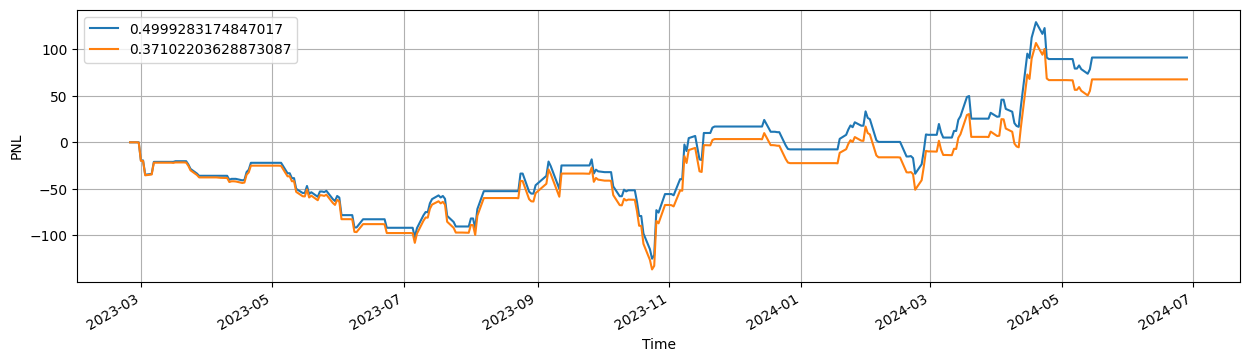

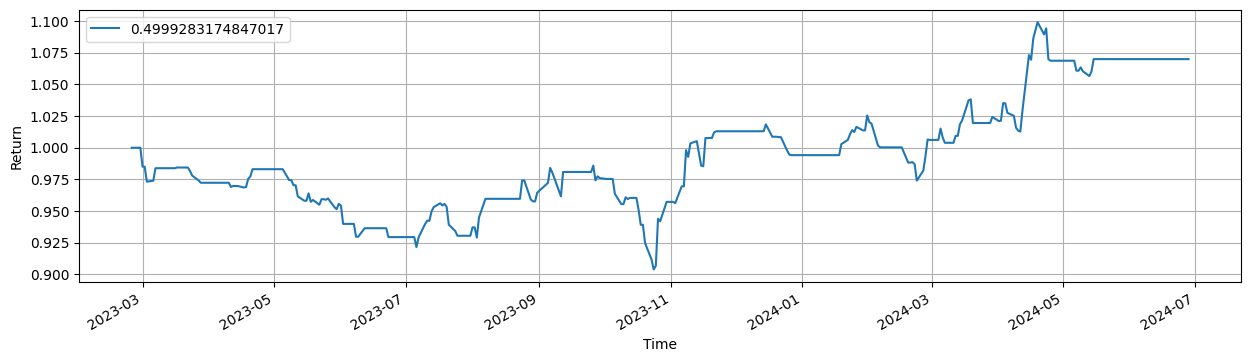

In [11]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 9.26136365081348
MDD: (82.91678571428614, 0.06442440461390954)

   Total trading quantity: 51
         Profit per trade: 2.142156862745107
             Total Profit: 109.3
         Profit after fee: 87.1
 Trading quantity per day: 0.15178571428571427
 Profit per day after fee: 0.25922619047619044
                   Return: 0.05030804987031612
          Profit per year: 64.74847250509166
                  HitRate: 0.49019607843137253
          HitRate per day: 0.23283582089552238


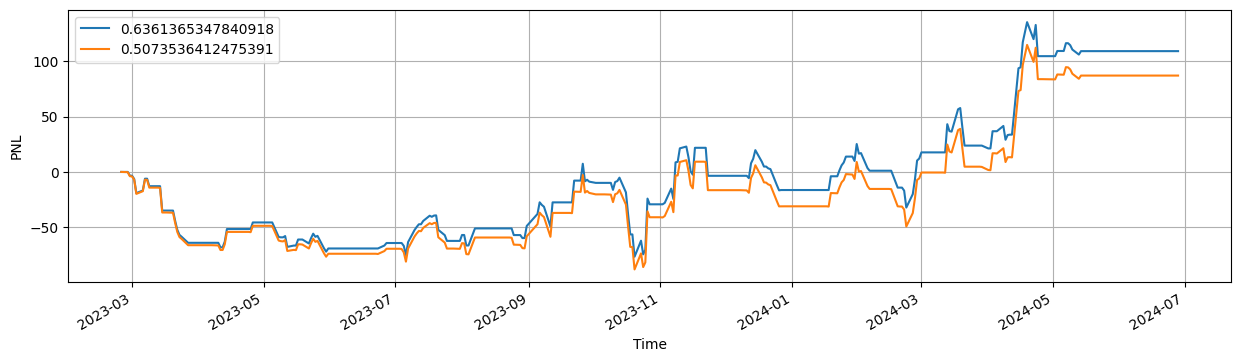

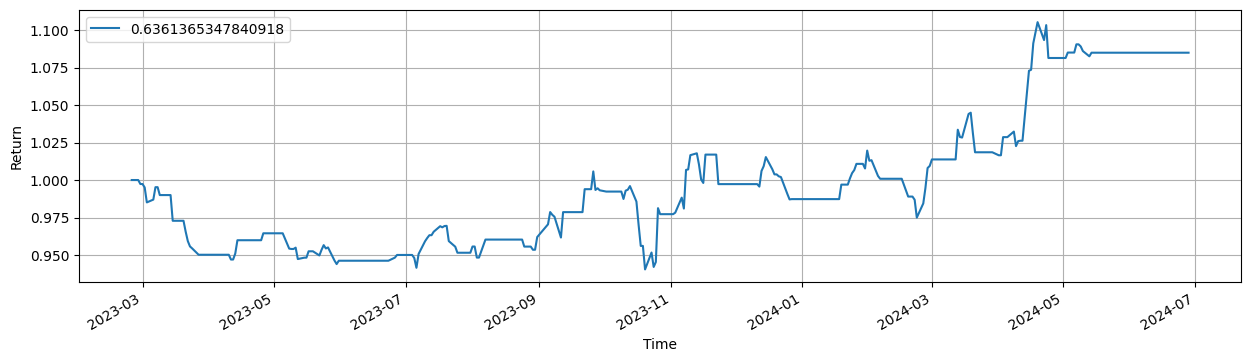

In [12]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [13]:
%%capture
data_VNI_position = test(data_VNI, 7)
data_VN30_position = test(data_VN30, 7)

Margin: 2.625979472411548
MDD: (183.9680357142862, 0.14302887952721224)

   Total trading quantity: 54
         Profit per trade: 0.610185185185165
             Total Profit: 32.9
         Profit after fee: 9.4
 Trading quantity per day: 0.16071428571428573
 Profit per day after fee: 0.027976190476190477
                   Return: 0.005432760890924017
          Profit per year: 6.987780040733198
                  HitRate: 0.5
          HitRate per day: 0.3641791044776119


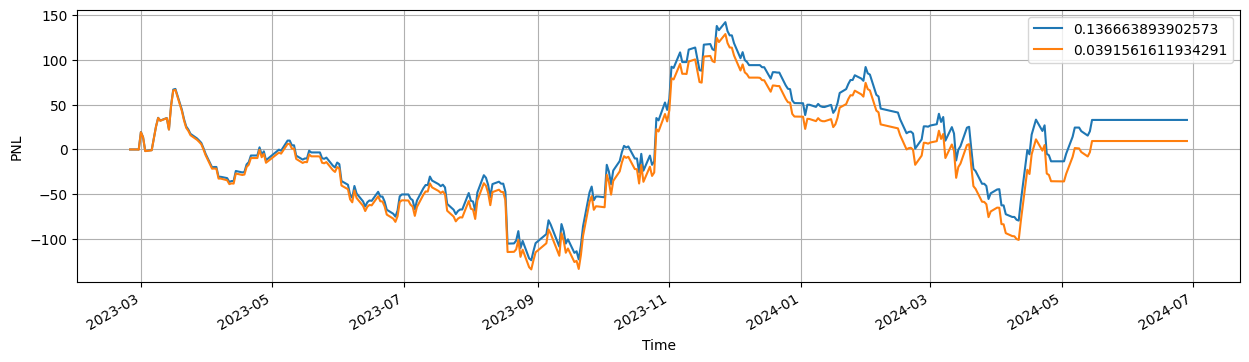

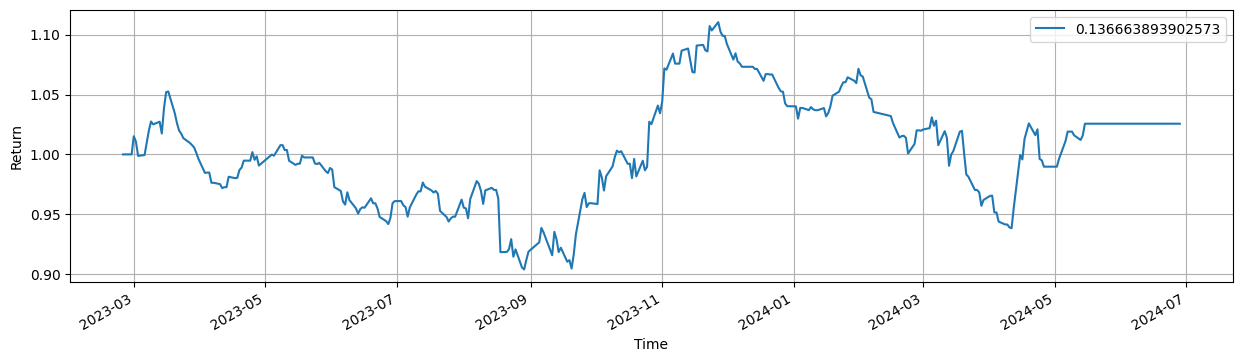

In [14]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 9.520557181608297
MDD: (171.7587797619051, 0.135471408327343)

   Total trading quantity: 61
         Profit per trade: 2.1978688524590155
             Total Profit: 134.1
         Profit after fee: 107.5
 Trading quantity per day: 0.18154761904761904
 Profit per day after fee: 0.31994047619047616
                   Return: 0.0630301783755253
          Profit per year: 79.91344195519349
                  HitRate: 0.5409836065573771
          HitRate per day: 0.4059701492537313


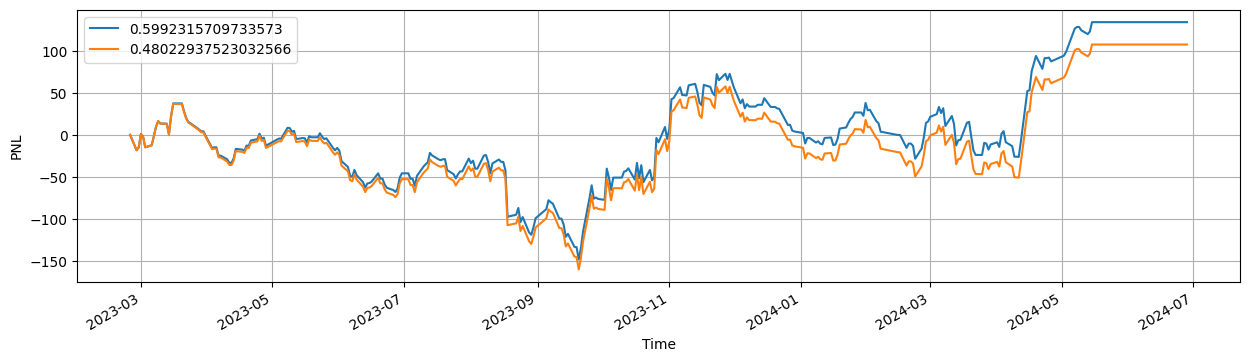

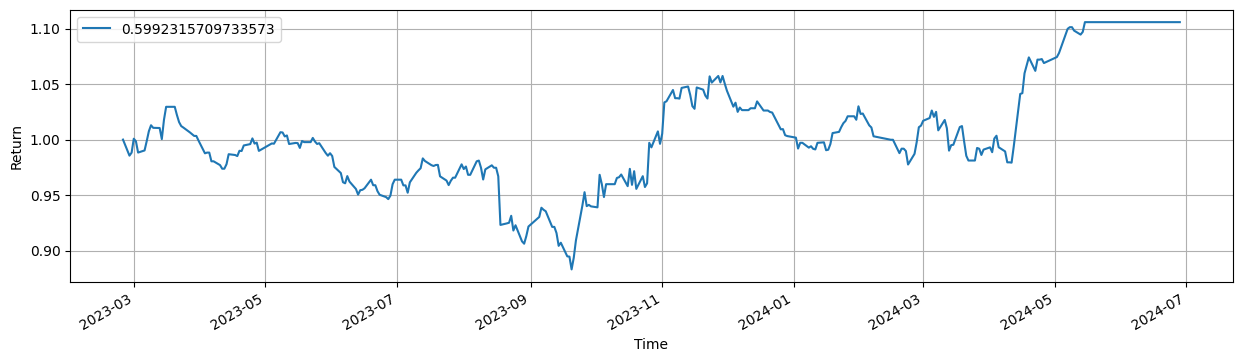

In [15]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [16]:
%%capture
data_VNI_position = test(data_VNI, 3)
data_VN30_position = test(data_VN30, 3)

Margin: -2.2943559967776754
MDD: (230.50690476190533, 0.1783694999318311)

   Total trading quantity: 104
         Profit per trade: -0.5293269230769292
             Total Profit: -55.1
         Profit after fee: -103.5
 Trading quantity per day: 0.30952380952380953
 Profit per day after fee: -0.3080357142857143
                   Return: -0.059537196110504446
          Profit per year: -76.9399185336049
                  HitRate: 0.47115384615384615
          HitRate per day: 0.33432835820895523


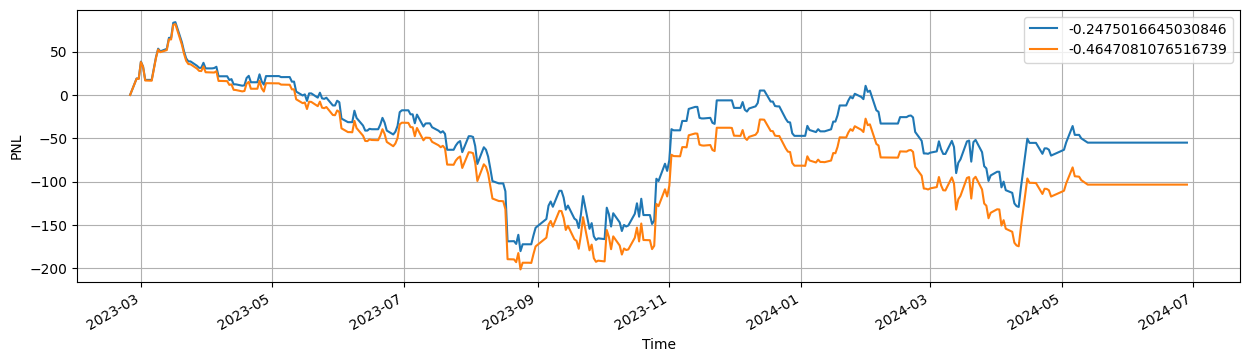

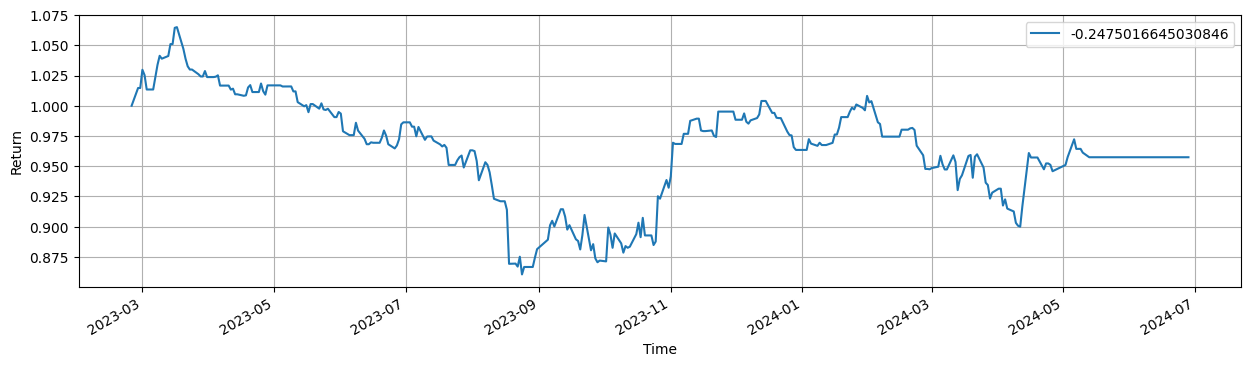

In [17]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: -9.483448793164902
MDD: (238.6831547619055, 0.18545123287691564)

   Total trading quantity: 103
         Profit per trade: -2.187378640776712
             Total Profit: -225.3
         Profit after fee: -273.4
 Trading quantity per day: 0.30654761904761907
 Profit per day after fee: -0.8136904761904761
                   Return: -0.15791298317502211
          Profit per year: -203.24032586558044
                  HitRate: 0.46601941747572817
          HitRate per day: 0.3402985074626866


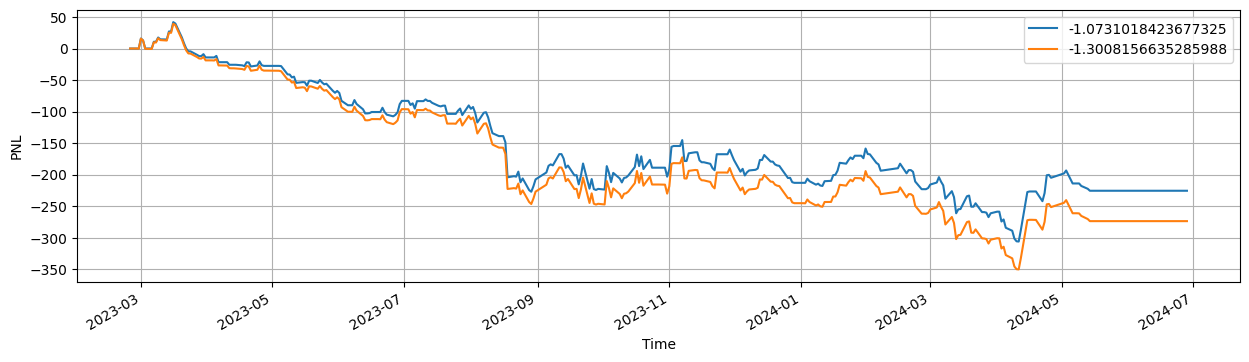

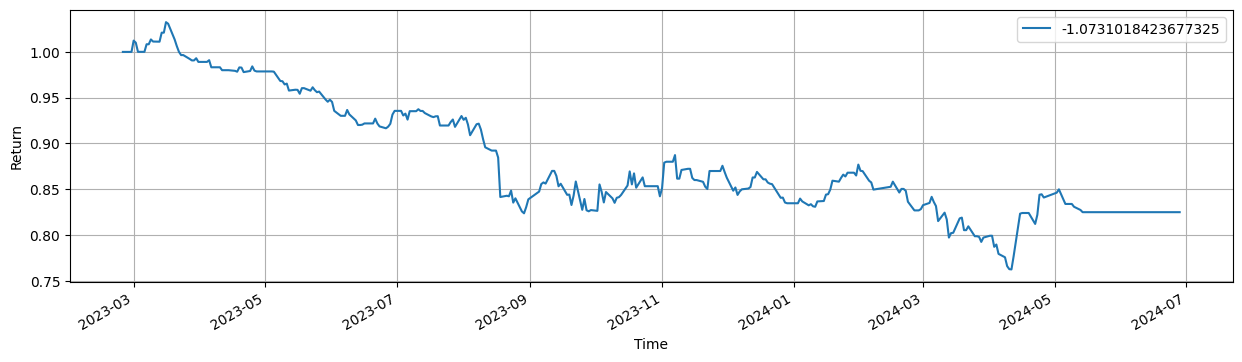

In [18]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [19]:
%%capture
data_VNI_position = test(data_VNI, 200)
data_VN30_position = test(data_VN30, 200)

Margin: 5.9380889680638775
MDD: (1.180327380952399, 0.0010151781925829971)

   Total trading quantity: 1
         Profit per trade: 1.3800000000001091
             Total Profit: 1.4
         Profit after fee: 1.0
 Trading quantity per day: 0.002976190476190476
 Profit per day after fee: 0.002976190476190476
                   Return: 0.0006393684035135624
          Profit per year: 0.7433808553971487
                  HitRate: 1.0
          HitRate per day: 0.0029850746268656717


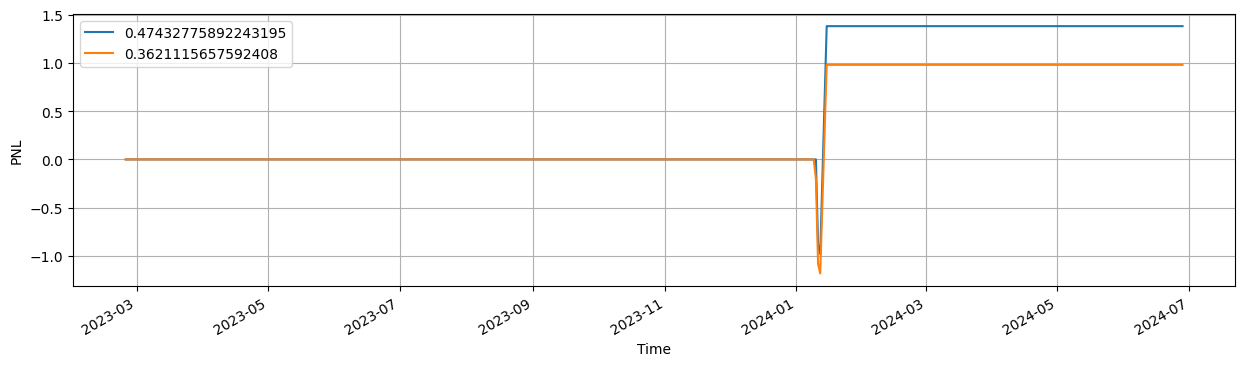

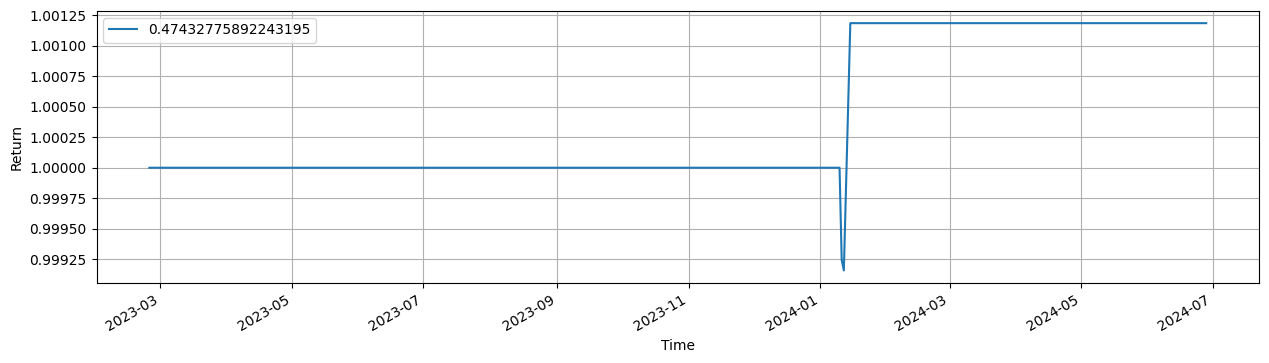

In [20]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()